# CNN


In [1]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        
        self.pool1 = nn.MaxPool2d(2, 2)
        self.pool2 = nn.MaxPool2d(3, 3)

        self.fc1 = nn.Linear(25 * 25 * 64, 1280)
        self.fc2 = nn.Linear(1280, 8)
        
    def forward(self, x, extract_features=False):
        x = self.pool1(F.relu(self.conv1(x)))
        # print(x.shape)
        x = self.pool2(F.relu(self.conv2(x)))
        # print(x.shape)
        x = self.pool1(F.relu(self.conv3(x)))
        # print(x.shape)
        
        x = x.view(-1, 25 * 25 * 64)
        
        x = self.fc1(x)
        if not extract_features:
            x = self.fc2(x)
        return x


# SimpleCNN 
simple_cnn = SimpleCNN()
print(simple_cnn)



SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=40000, out_features=1280, bias=True)
  (fc2): Linear(in_features=1280, out_features=8, bias=True)
)


In [2]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os


class MyDataset(Dataset):
    def __init__(self, dataframe, image_set_path, transform=None):
        self.dataframe = dataframe
        self.image_set_path = image_set_path
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]  
        probability  = self.dataframe.iloc[idx, 1] 
        module  = self.dataframe.iloc[idx, 2] 

        yLabel = module*4 + probability 
        
        img_path = os.path.join(self.image_set_path, img_name)
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        return image, yLabel

transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
])


# 分布可视化
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools


def confusionBox(y_true, y_pred):

    cm = confusion_matrix(y_true, y_pred)

    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('box')
    plt.colorbar()

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('ans')
    plt.xlabel('per')
    plt.xticks(np.arange(len(np.unique(y_true))))
    plt.yticks(np.arange(len(np.unique(y_true))))
    plt.tight_layout()
    plt.show()

def confusionBoxPer(y_true, y_pred):

    cm = confusion_matrix(y_true, y_pred)
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    plt.imshow(cm_percentage, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix (Percentage)')
    plt.colorbar()

    thresh = cm_percentage.max() / 2.
    for i, j in itertools.product(range(cm_percentage.shape[0]), range(cm_percentage.shape[1])):
        plt.text(j, i, "{:0.1f}%".format(cm_percentage[i, j]),
                 horizontalalignment="center",
                 color="white" if cm_percentage[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.xticks(np.arange(len(np.unique(y_true))))
    plt.yticks(np.arange(len(np.unique(y_true))))
    plt.tight_layout()
    plt.show()




In [3]:
import os
path = os.getcwd()
csv_path = path + '/elpv-dataset/labels.csv'
image_set_path = path + '/elpv-dataset/'

dataset = MyDataset(csv_path, image_set_path, transform=transform)

In [4]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split


path = os.getcwd()
csv_path = path + '/elpv-dataset/labels.csv'
image_set_path = path + '/elpv-dataset/'

dataframe = pd.read_csv(csv_path,  header=None, sep='\s+')
dataframe.columns = ['image_path', 'label', 'bool_value']
dataframe['label'] = dataframe['label'].replace({0: 0, 1/3:1, 2/3:2, 1: 3})
dataframe['label'] = dataframe['label'].astype(int)

dataframe['bool_value'] = dataframe['bool_value'].replace({'mono': 0, 'poly': 1})




#  train_val_df, test_df = 9:1
train_val_df, test_df = train_test_split(dataframe, test_size=0.1, random_state=42)

# train_df, val_df = 9:1
train_df, val_df = train_test_split(train_val_df, test_size=0.1 / 1, random_state=42)

# get dataset
train_dataset = MyDataset(train_df, image_set_path, transform=transform)
val_dataset = MyDataset(val_df, image_set_path, transform=transform)
test_dataset = MyDataset(test_df, image_set_path, transform=transform)

# create DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

dataframe.head()

# some detils
print('dataSetLen: ', len(train_df), len(val_df), len(test_df), end='\n\n')
print('dataSetCol: ', train_df.columns, end='\n\n')

print('---------per-------')
# 查看‘label’ 和 ‘bool_value’的数量
print('dataSetLabel: ', train_df['label'].value_counts(), end='\n\n')
print('dataSetBool: ', train_df['bool_value'].value_counts(), end='\n\n')
print(train_df.groupby(['bool_value', 'label']).size())
yClass = train_df.groupby(['bool_value', 'label']).size()



dataSetLen:  2124 237 263

dataSetCol:  Index(['image_path', 'label', 'bool_value'], dtype='object')

---------per-------
dataSetLabel:  label
0    1213
3     581
1     240
2      90
Name: count, dtype: int64

dataSetBool:  bool_value
1    1259
0     865
Name: count, dtype: int64

bool_value  label
0           0        466
            1         95
            2         48
            3        256
1           0        747
            1        145
            2         42
            3        325
dtype: int64


Epoch 1: 100%|██████████| 133/133 [00:07<00:00, 17.29it/s]


Epoch 1, Train Loss: 0.15109606907191805
Epoch 1, Validation Loss: 3.0361930688222247, Validation Accuracy: 0.6666666666666666


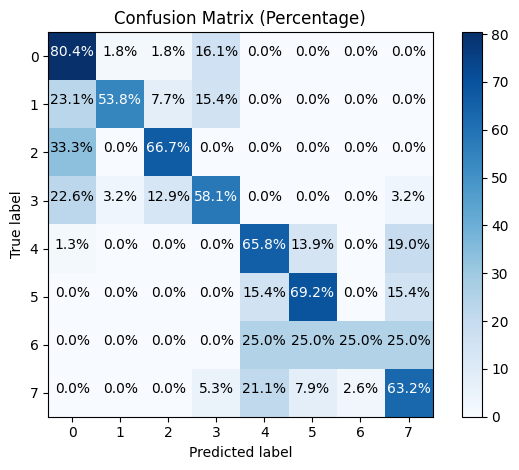

In [5]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from tqdm import tqdm 

# 1. 
model = SimpleCNN()

# 2
model.load_state_dict(torch.load("model.ckpt"))

# 3 criterion and optimizer
criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

# cuda
if torch.cuda.is_available():
    model = model.cuda()

# 4. fit
num_epochs = 1

for epoch in range(num_epochs):
    y_true_labels = []
    y_pred_labels = []
    model.train()
    train_loss = 0
    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}"):
        images, labels = batch

        if torch.cuda.is_available():
            images, labels = images.cuda(), labels.cuda()

        # forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # get labels
        _, predicted = torch.max(outputs.data, 1)
        y_true_labels.extend(labels.cpu().numpy())
        y_pred_labels.extend(predicted.cpu().numpy())

        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_dataloader)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}")

    # validation
    model.eval()
    val_loss = 0
    val_corrects = 0
    y_true_val = []
    y_pred_val = []
    with torch.no_grad():
        for images, labels in val_dataloader:
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)

             # get labels
            y_true_val.extend(labels.cpu().numpy())
            y_pred_val.extend(preds.cpu().numpy())

    val_loss /= len(val_dataloader)
    val_accuracy = val_corrects.double() / len(val_dataloader.dataset)
    print(f"Epoch {epoch+1}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
    confusionBoxPer(y_true_val, y_pred_val)

# save model
torch.save(model.state_dict(), "model.ckpt")

# Only Random Forest Run

In [9]:
from sklearn.ensemble import RandomForestClassifier


# getDataSet
def getDataSet(dataloader):
    x = []
    y = []
    for batch in dataloader:
        images, labels = batch
        # from torch.Size([16, 1, 300, 300]) to torch.Size([16, 90000])
        x.append(images.view(images.size(0), -1))  # images.size(0) 
        y.extend(labels.tolist())  
    x = torch.cat(x, 0)
    y = torch.tensor(y)
    return x, y


x_train, y_train = getDataSet(train_dataloader)
x_val, y_val = getDataSet(val_dataloader)
x_test, y_test = getDataSet(test_dataloader)

In [10]:
# initialize the random forest classifier
random_forest_classifier = RandomForestClassifier(n_estimators=1000, random_state=42, max_depth=10)

# train the model
random_forest_classifier.fit(x_train.numpy(), y_train.numpy())

RandomForestClassifier(max_depth=10, n_estimators=1000, random_state=42)

Validation Accuracy: 0.7088607594936709


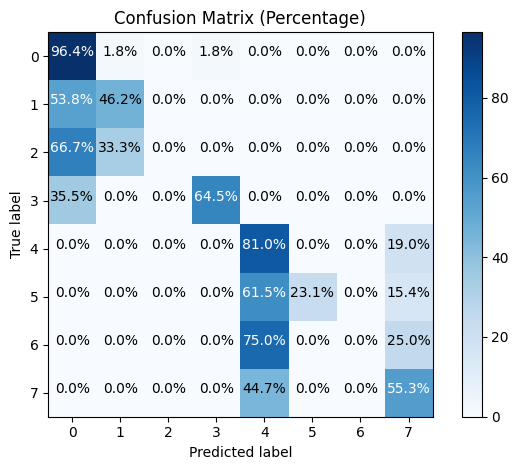

Test Accuracy: 0.7338403041825095


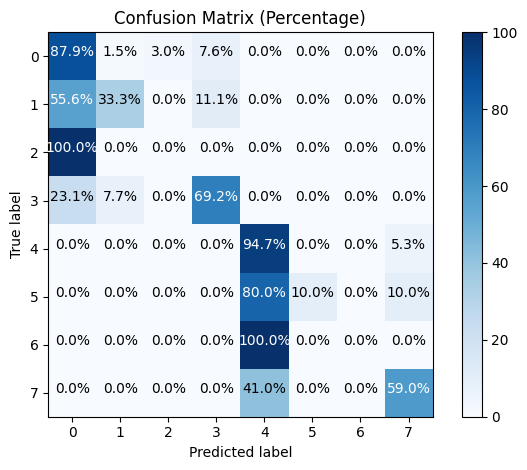

In [11]:
# evaluate the model at val set
val_predictions = random_forest_classifier.predict(x_val.numpy())
val_accuracy = np.mean(val_predictions == y_val.numpy())
print(f"Validation Accuracy: {val_accuracy}")
confusionBoxPer(y_val.numpy(), val_predictions)


# evaluate the model at test set
test_predictions = random_forest_classifier.predict(x_test.numpy())
test_accuracy = np.mean(test_predictions == y_test.numpy())
print(f"Test Accuracy: {test_accuracy}")
confusionBoxPer(y_test.numpy(), test_predictions)